## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
aou_variants_file_path = data_path + 'aou_variants.tsv.gz'
gene_annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
genome_coverage_file_path = data_path + 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'
coverage_file_path = data_path + 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'

## Define helper methods

In [3]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df, gene_df=None):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create a boolean mask for the combined protein-coding regions
    protein_coding_mask = np.ones(sequence_length + 1, dtype=bool)
    
    # If gene_df is given, create filter for protein-coding regions
    if gene_df is not None:
        # Get the length of the genetic sequence
        sequence_length = max(gene_df['end'].max(), coverage_df['pos'].max(), variants_df['pos'].max())

        # Create a boolean mask for the combined protein-coding regions
        protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

        # Use NumPy boolean indexing to set True for positions between 'start' and 'end' of the region
        for start, end in zip(gene_df['start'].to_numpy(), gene_df['end'].to_numpy()):
            protein_coding_mask[start:end+1] = 1

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[protein_coding_mask & coverage_mask])
    
    positions = np.where(protein_coding_mask & coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def fit_and_predict_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df
    
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

## Load data

In [4]:
with gzip.open(coverage_file_path, 'rt') as coverage_file:
    # Read the file into a pandas DataFrame
    coverage_df = pd.read_csv(coverage_file, sep='\t',
                             usecols=['locus', 'over_10', 'over_20'])

# Expand locus column
coverage_df[['chr', 'pos']] = coverage_df['locus'].str.split(':', expand=True)
coverage_df['pos'] = coverage_df['pos'].astype(int)

# Drop the original locus column
coverage_df = coverage_df.drop('locus', axis=1)

coverage_df

,over_10,over_20,chr,pos
0,0.00000,0.00000,chr1,11819
1,0.00000,0.00000,chr1,11820
2,0.00000,0.00000,chr1,11821
3,0.00000,0.00000,chr1,11822
4,0.00000,0.00000,chr1,11823
...,...,...,...,...
170202922,0.29592,0.23756,chrM,16069
170202923,0.29582,0.23788,chrM,16070
170202924,0.29689,0.23808,chrM,16071
170202925,0.29674,0.23815,chrM,16072


In [5]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(gene_annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201


In [6]:
# Initialize an empty dataframe to store the concatenated data
aou_variants_df = pd.DataFrame()

# Check if the joined file already exists
if not os.path.exists(aou_variants_file_path):
    # Loop through chromosomes and append dataframes with tqdm
    for filenum in tqdm(range(1, 9), desc='Processing Files'):
        # Read the variants file into a pandas DataFrame
        file_variants_df = pd.read_csv(
            data_path + "output_prefix_0" + str(filenum) + ".tsv.gz",
            sep='-',
            skiprows=1,
            usecols=[0,1],
            names=['chr', 'pos'],
            dtype={'chr': str, 'pos': int},
        )
        
        file_variants_df.drop_duplicates(inplace=True)

        # Append the dataframe to the main dataframe
        aou_variants_df = pd.concat([aou_variants_df, file_variants_df], ignore_index=True)
    
    # Add chr prefix for consistency
    aou_variants_df['chr'] = 'chr' + aou_variants_df['chr'].astype(str)
    
    # Write aou_variants_df to a csv to avoid recomputing
    aou_variants_df.to_csv(aou_variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    aou_variants_df = pd.read_csv(aou_variants_file_path, sep='\t')

# aou_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr1']
    
aou_variants_df

,chr,pos
0,chr1,10001
1,chr1,10073
2,chr1,10108
3,chr1,10110
4,chr1,10113
...,...,...
934655699,chrY,56887741
934655700,chrY,56887744
934655701,chrY,56887793
934655702,chrY,56887802


## Train HMM on AoU chromosome 2 and get predictions for full genome

In [5]:
# Define coverage filter
coverage_filter = '0.5_over10' # coverage['over10'] > 0.5
# coverage_filter = '0.9_over20' # coverage['over20'] > 0.9

# Define pattern for coverage file paths
# coverage_file_prefix = data_path + 'gnomad.genomes.r3.0.1.coverage_0.5_over10_chr'
coverage_file_prefix = data_path + 'gnomad_r3_coverage/' + 'gnomad.genomes.r3.0.1.coverage_' + coverage_filter + '_chr'
coverage_file_suffix = '.summary.tsv.gz'

# Parameters for analysis
order = 2

# Define model name (and absolute path)
model_name = results_path + 'HMM_aou_' + coverage_filter + '_chr2'

# Define path to trained HMM
hmm_file_path = model_name + '_model.joblib'

if os.path.exists(hmm_file_path):
    # Load the pretrained model
    model = joblib.load(hmm_file_path)
    
else:
    # Filter rows for chromosome 2
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr2']
    chr_coverage_df = pd.read_csv(coverage_file_prefix + '2' + coverage_file_suffix, sep='\t', names=['pos'])

    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

    # Fit HMM to Chromosome 2
    model = fit_HMM(observations, order=order)

    # Save the HMM model to a file to avoid retraining
    joblib.dump(model, hmm_file_path)

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


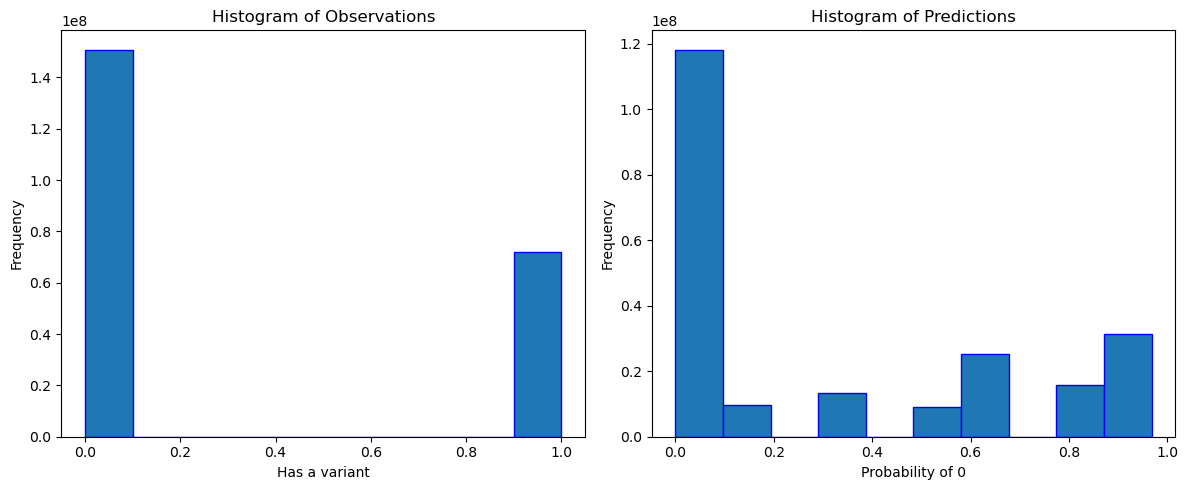

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                 1.044e+08
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:02:49   Log-Likelihood:            -1.0389e+08
No. Observations:           222708440   AIC:                         2.078e+08
Df Residuals:               222708438   BIC:                         2.078e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5406   3.35e-05   1.61e+04      0.0

,chr,pos,prob_0,prob_1,observation
0,chr1,10008,2.621396e-35,1.000000,0.0
1,chr1,10009,6.635308e-01,0.336469,0.0
2,chr1,10010,8.721616e-01,0.127838,0.0
3,chr1,10011,9.377604e-01,0.062240,0.0
4,chr1,10012,9.583863e-01,0.041614,0.0
...,...,...,...,...,...
222708435,chr1,248946239,2.097344e-06,0.999998,1.0
222708436,chr1,248946240,2.097344e-06,0.999998,1.0
222708437,chr1,248946241,2.097344e-06,0.999998,1.0
222708438,chr1,248946242,2.097565e-06,0.999998,1.0


In [6]:
# for chromnum in range(1,23):
for chromnum in [1,]:
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr' + str(chromnum)]
    chr_coverage_df = pd.read_csv(coverage_file_prefix + str(chromnum) + coverage_file_suffix, sep='\t', names=['pos'])
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    predictions_file_prefix = model_name + "_predictions_aou_chr"
    
    # Checkpoint chr_predictions_df to a csv to avoid memory bottleneck
    chr_predictions_df.to_csv(predictions_file_prefix + str(chromnum) + ".tsv.gz", index=False, compression='gzip', sep='\t')
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)
    
chr_predictions_df

## Get predictions for AoU WES from the HMM trained on RGC chromosome 2

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


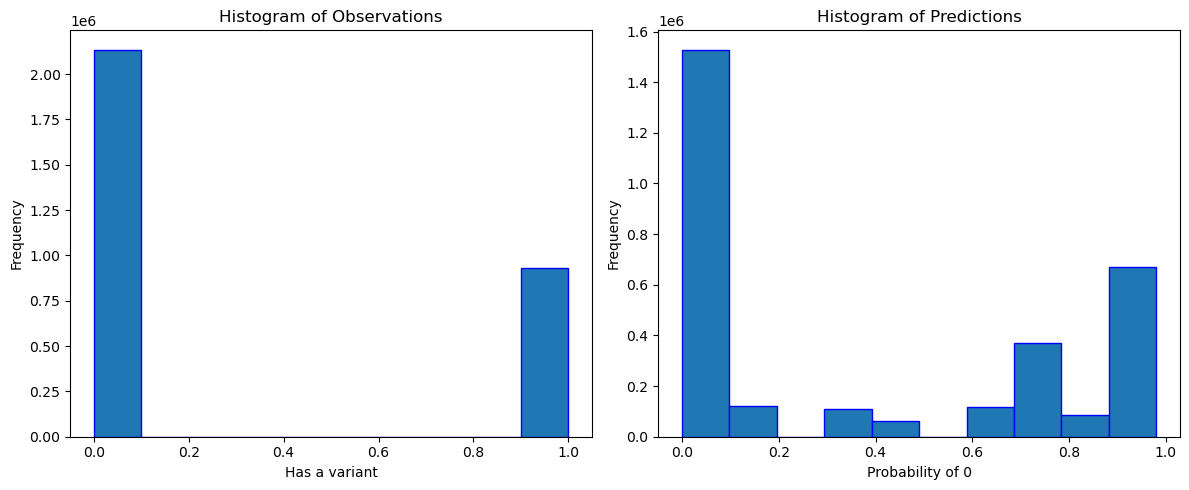

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                 1.691e+06
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:42   Log-Likelihood:            -1.2914e+06
No. Observations:             3062969   AIC:                         2.583e+06
Df Residuals:                 3062967   BIC:                         2.583e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5628      0.000   1937.859      0.0

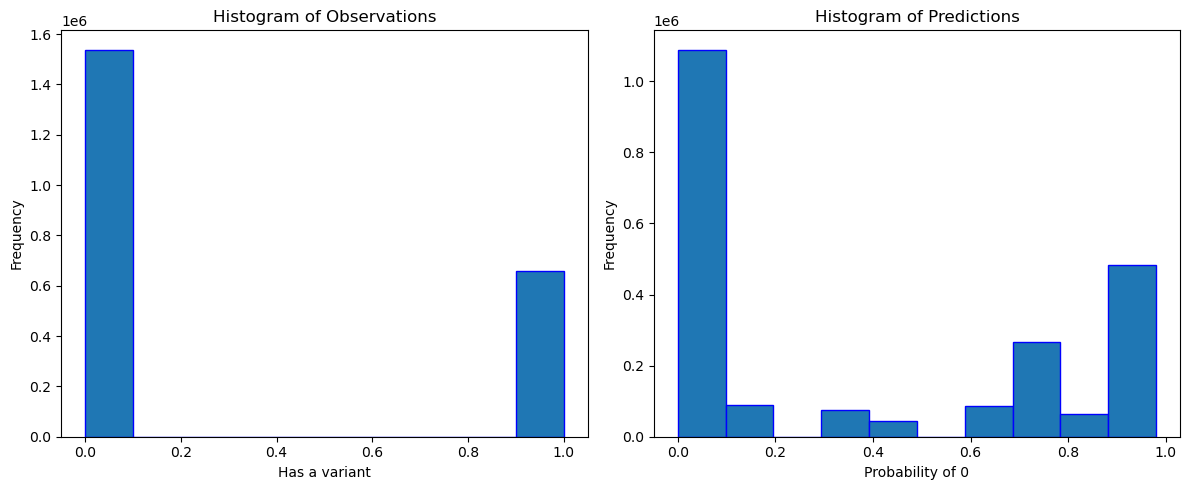

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 1.208e+06
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:06:55   Log-Likelihood:            -9.2106e+05
No. Observations:             2196811   AIC:                         1.842e+06
Df Residuals:                 2196809   BIC:                         1.842e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5603      0.000   1632.448      0.0

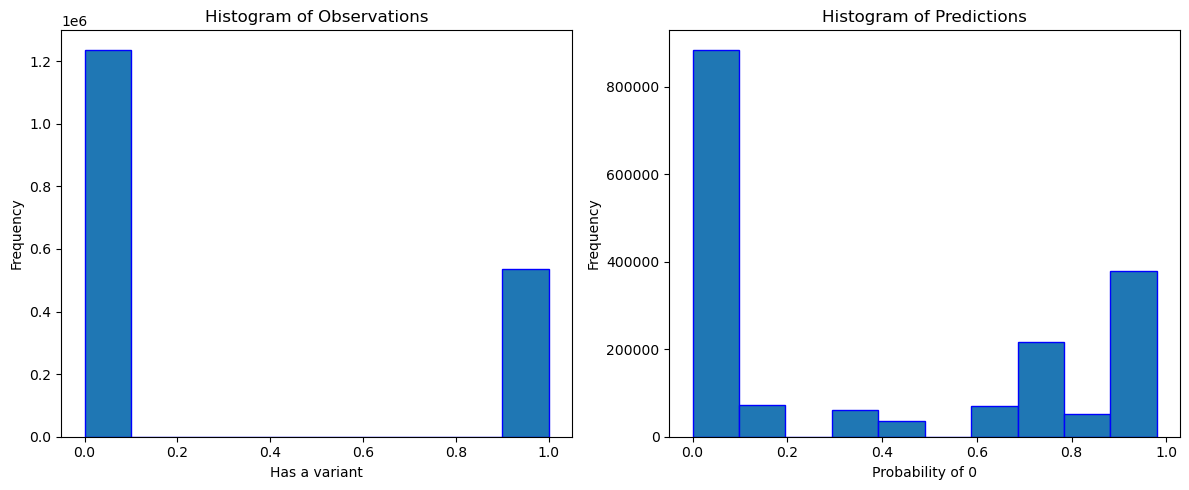

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 9.665e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:08:22   Log-Likelihood:            -7.4890e+05
No. Observations:             1771715   AIC:                         1.498e+06
Df Residuals:                 1771713   BIC:                         1.498e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5604      0.000   1465.999      0.0

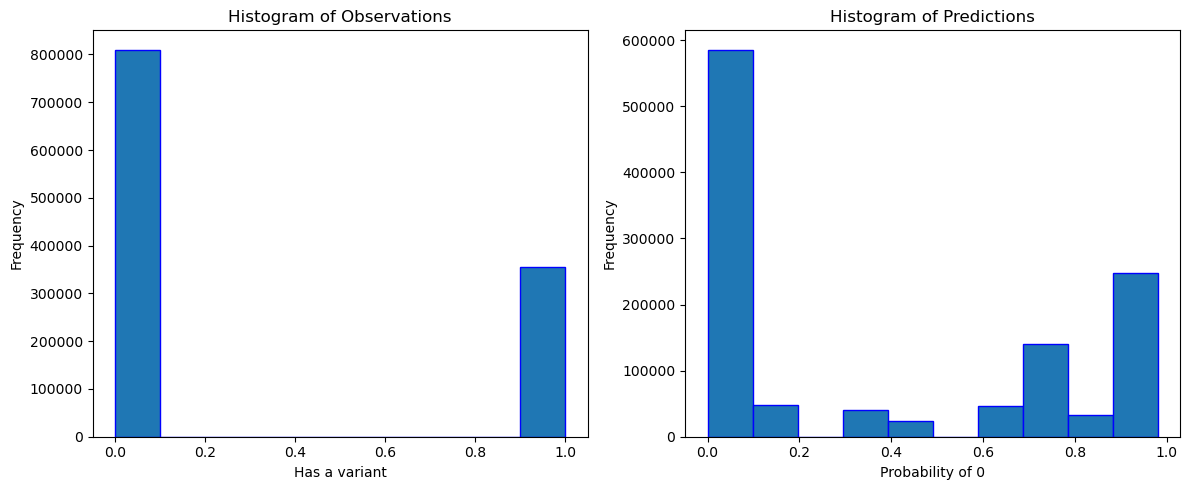

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                 6.303e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:09:31   Log-Likelihood:            -4.9617e+05
No. Observations:             1164104   AIC:                         9.923e+05
Df Residuals:                 1164102   BIC:                         9.924e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5606      0.000   1189.191      0.0

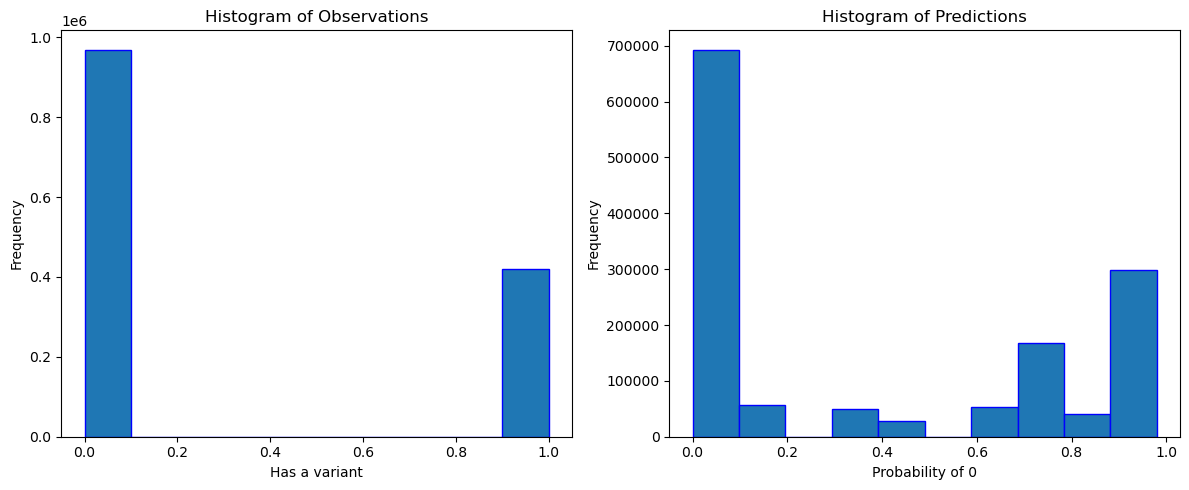

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 7.582e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:11:03   Log-Likelihood:            -5.8661e+05
No. Observations:             1388157   AIC:                         1.173e+06
Df Residuals:                 1388155   BIC:                         1.173e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5606      0.000   1298.402      0.0

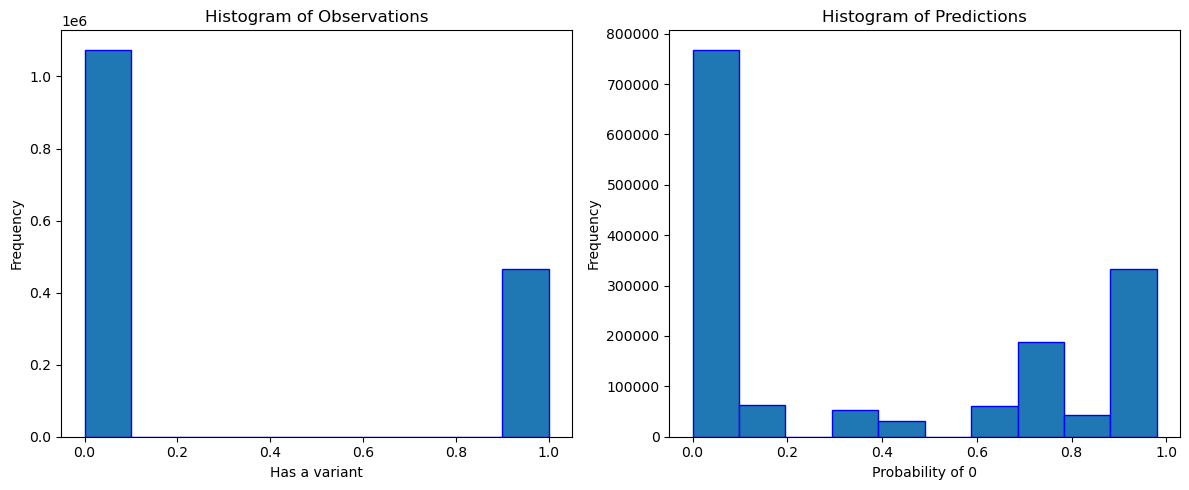

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 8.448e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:12:12   Log-Likelihood:            -6.4984e+05
No. Observations:             1539774   AIC:                         1.300e+06
Df Residuals:                 1539772   BIC:                         1.300e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5614      0.000   1369.868      0.0

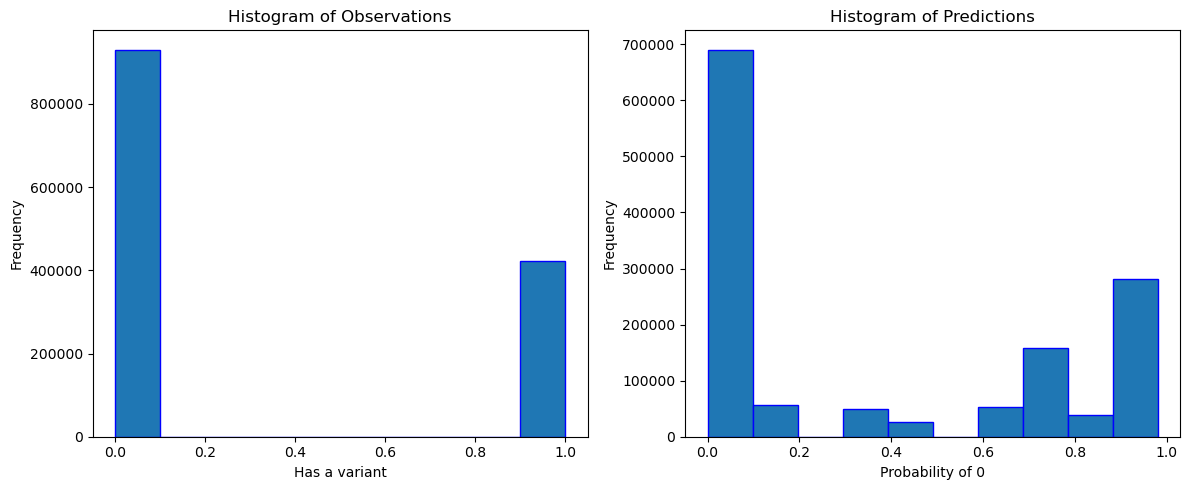

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 7.366e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:13:18   Log-Likelihood:            -5.8409e+05
No. Observations:             1352146   AIC:                         1.168e+06
Df Residuals:                 1352144   BIC:                         1.168e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5660      0.000   1296.963      0.0

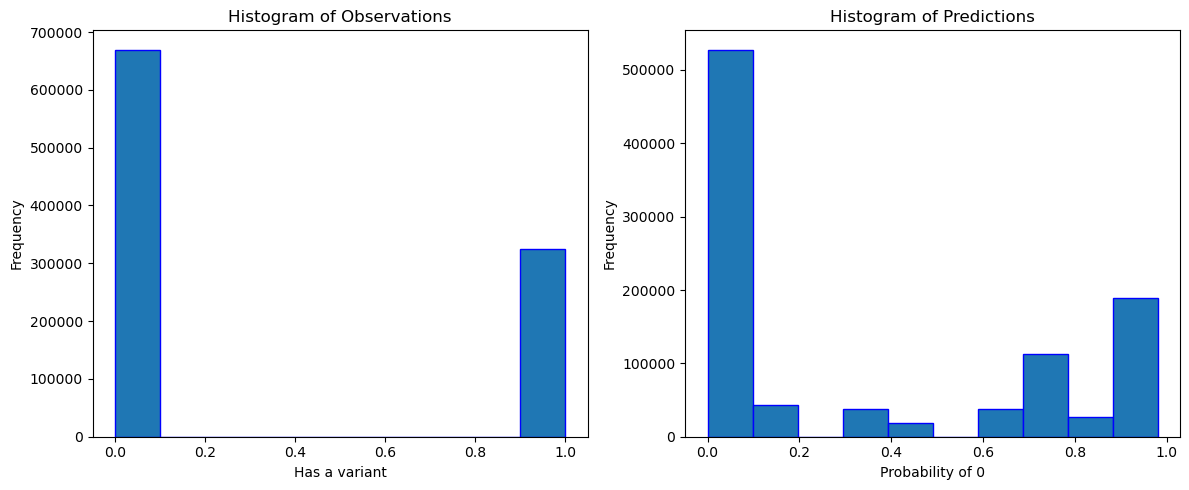

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                 5.297e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:14:23   Log-Likelihood:            -4.4622e+05
No. Observations:              994802   AIC:                         8.924e+05
Df Residuals:                  994800   BIC:                         8.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5718      0.001   1126.791      0.0

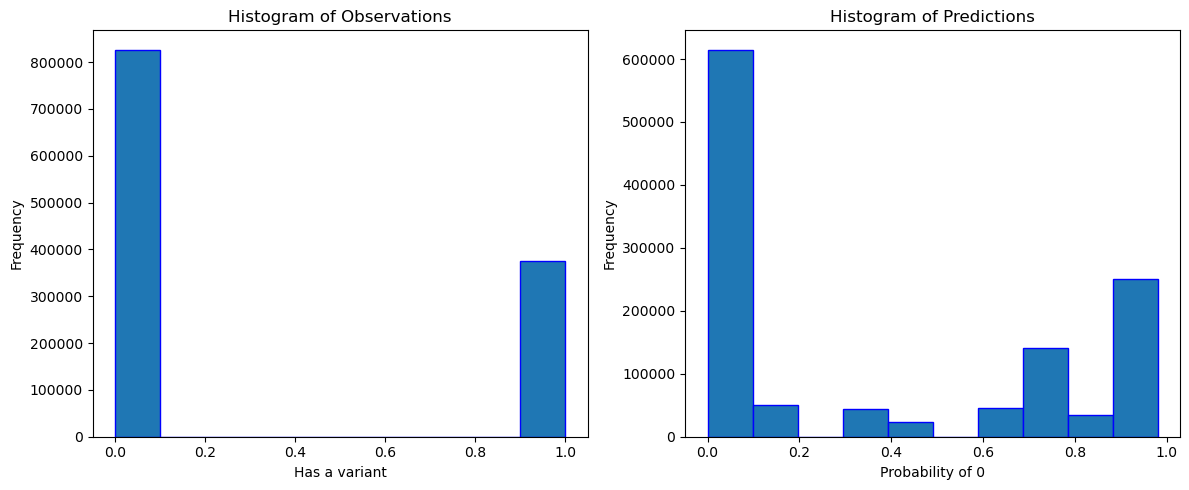

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 6.570e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:15:29   Log-Likelihood:            -5.1990e+05
No. Observations:             1202604   AIC:                         1.040e+06
Df Residuals:                 1202602   BIC:                         1.040e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5670      0.000   1225.821      0.0

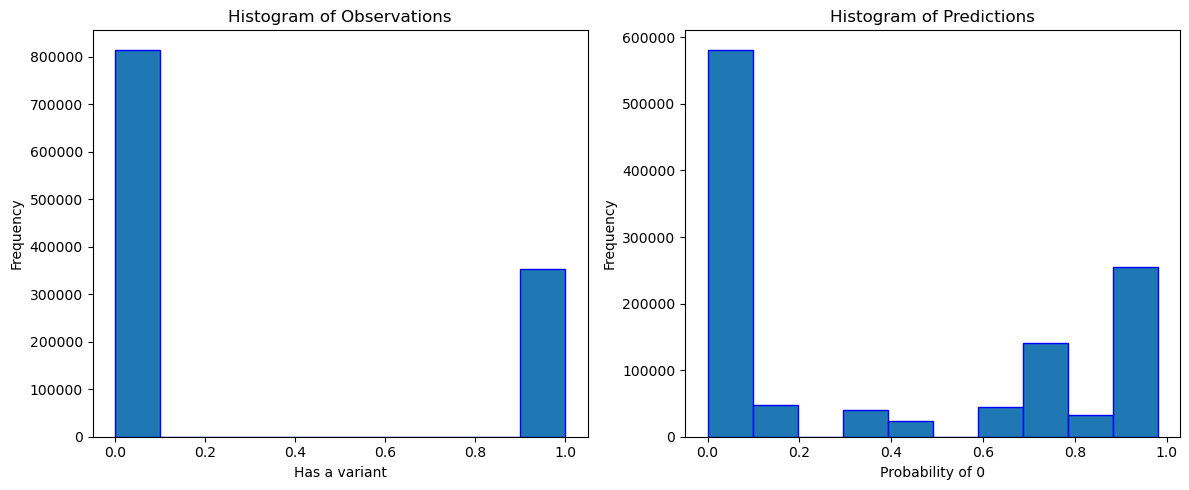

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                 6.444e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:16:33   Log-Likelihood:            -4.9157e+05
No. Observations:             1167847   AIC:                         9.831e+05
Df Residuals:                 1167845   BIC:                         9.832e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5622      0.000   1195.023      0.0

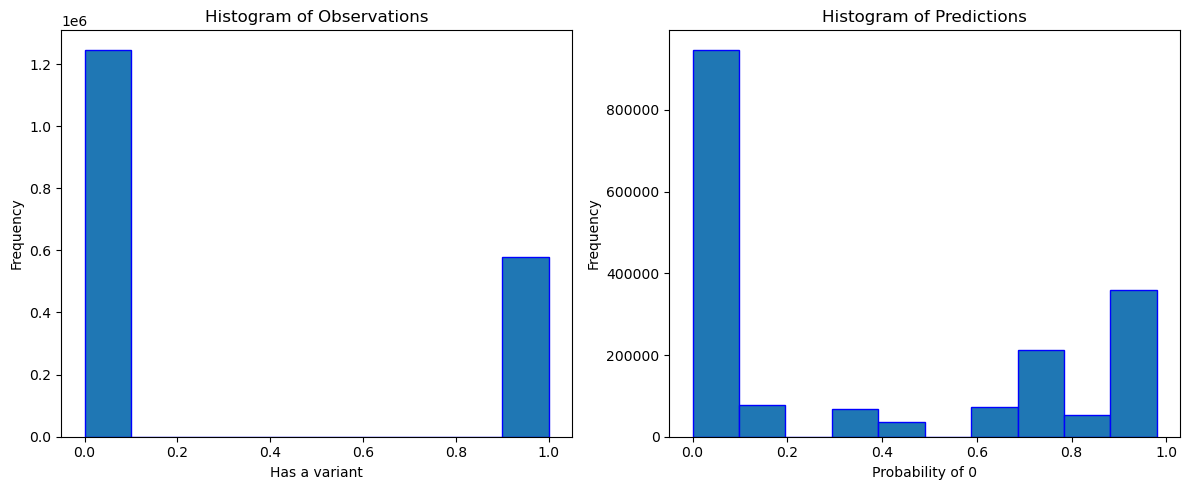

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                 9.792e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:17:38   Log-Likelihood:            -8.0286e+05
No. Observations:             1826028   AIC:                         1.606e+06
Df Residuals:                 1826026   BIC:                         1.606e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5671      0.000   1511.067      0.0

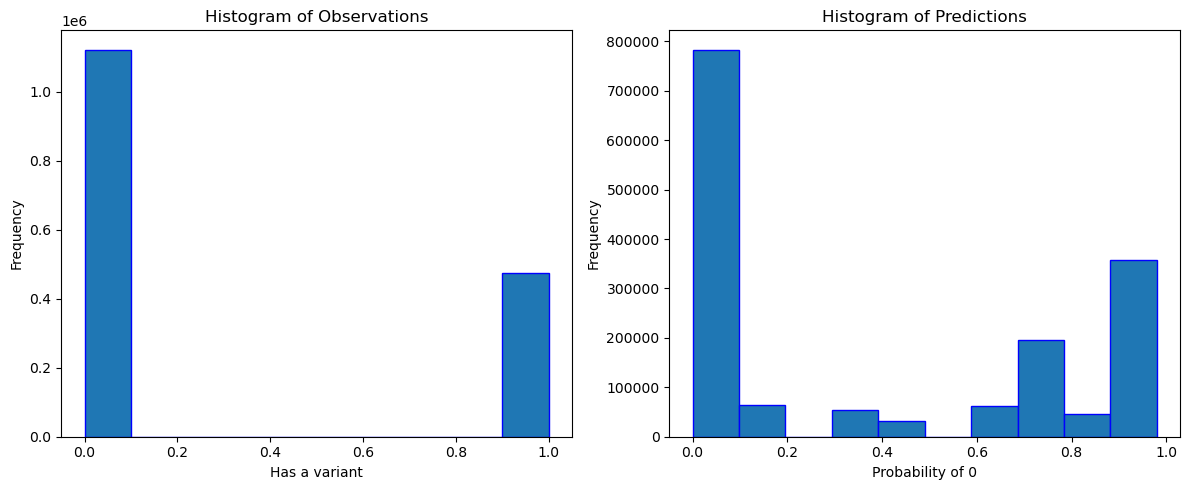

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 8.843e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:18:44   Log-Likelihood:            -6.6169e+05
No. Observations:             1595044   AIC:                         1.323e+06
Df Residuals:                 1595042   BIC:                         1.323e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5598      0.000   1388.893      0.0

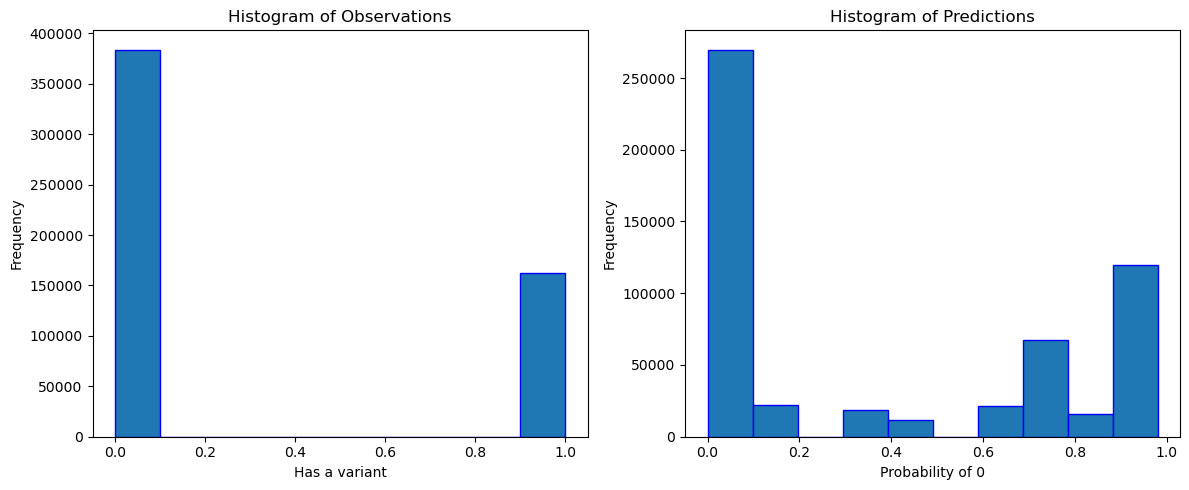

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 2.987e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:19:50   Log-Likelihood:            -2.2838e+05
No. Observations:              546314   AIC:                         4.568e+05
Df Residuals:                  546312   BIC:                         4.568e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5581      0.001    810.011      0.0

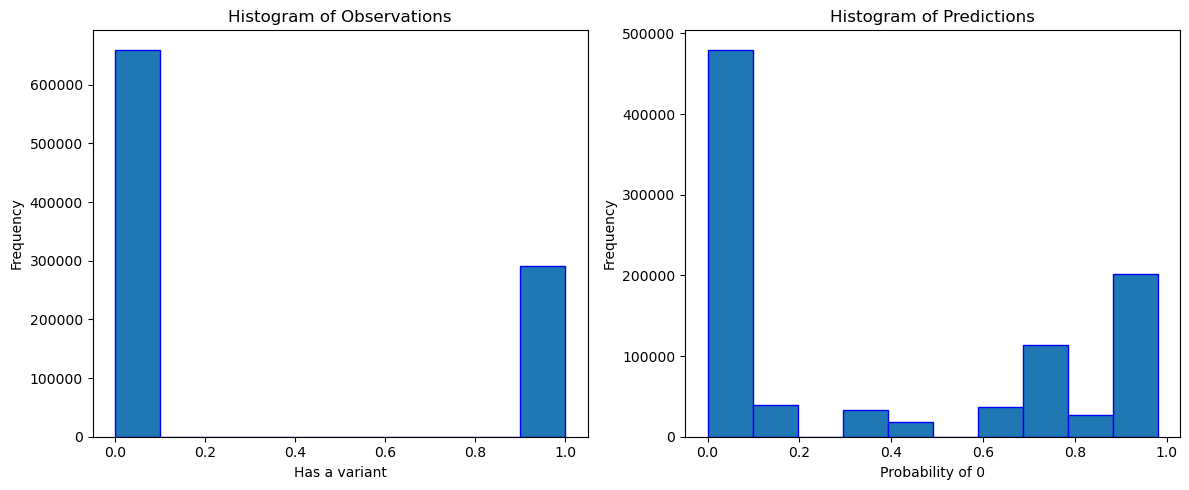

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 5.192e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:20:59   Log-Likelihood:            -4.0624e+05
No. Observations:              951587   AIC:                         8.125e+05
Df Residuals:                  951585   BIC:                         8.125e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5631      0.001   1080.951      0.0

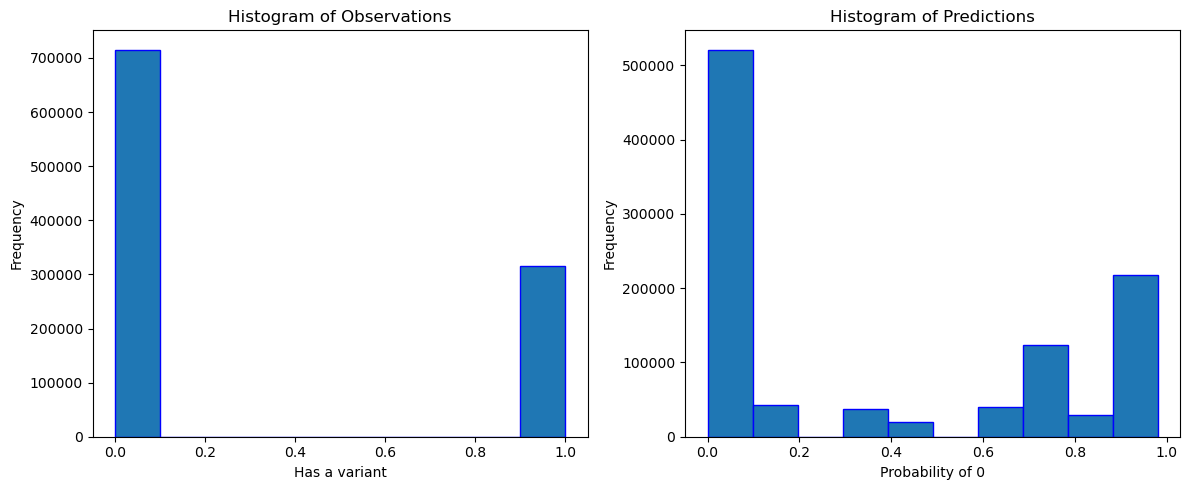

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                 5.598e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:22:05   Log-Likelihood:            -4.4148e+05
No. Observations:             1031557   AIC:                         8.830e+05
Df Residuals:                 1031555   BIC:                         8.830e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5622      0.001   1123.665      0.0

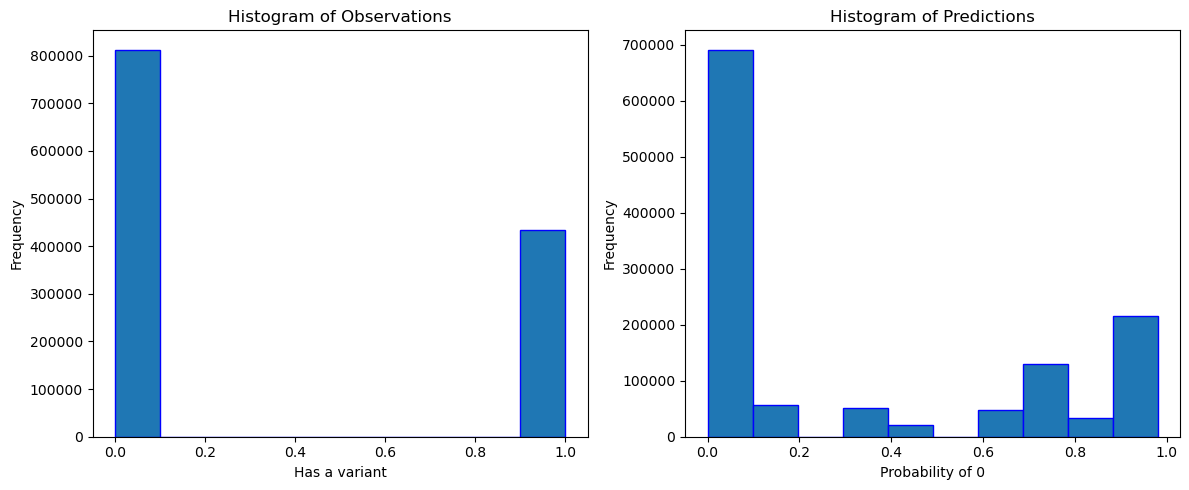

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 6.521e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:23:16   Log-Likelihood:            -5.8188e+05
No. Observations:             1246246   AIC:                         1.164e+06
Df Residuals:                 1246244   BIC:                         1.164e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5820      0.000   1290.291      0.0

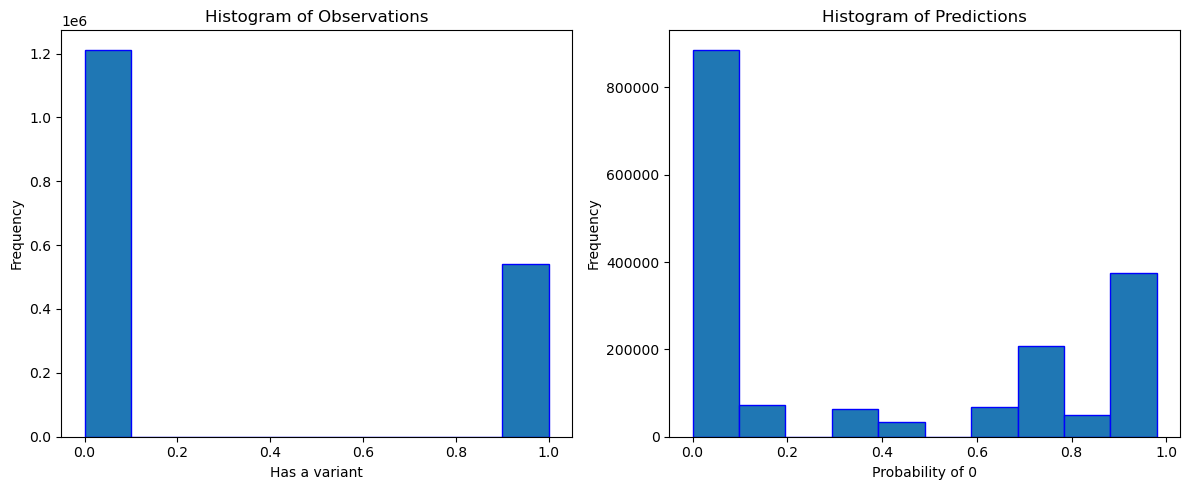

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                 9.695e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:24:21   Log-Likelihood:            -7.4850e+05
No. Observations:             1753740   AIC:                         1.497e+06
Df Residuals:                 1753738   BIC:                         1.497e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5665      0.000   1478.330      0.0

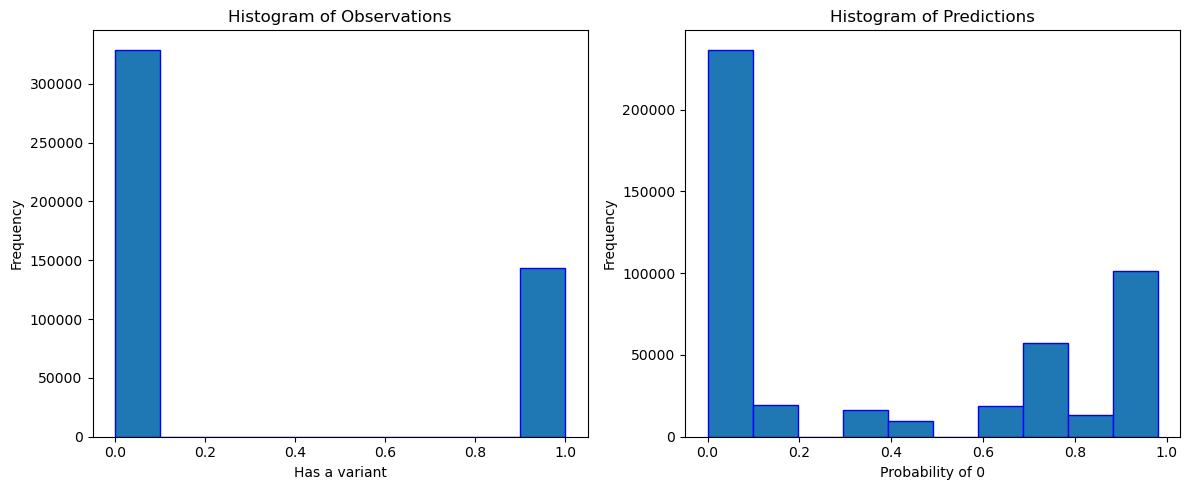

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 2.584e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:25:24   Log-Likelihood:            -2.0022e+05
No. Observations:              472322   AIC:                         4.004e+05
Df Residuals:                  472320   BIC:                         4.005e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5618      0.001    759.404      0.0

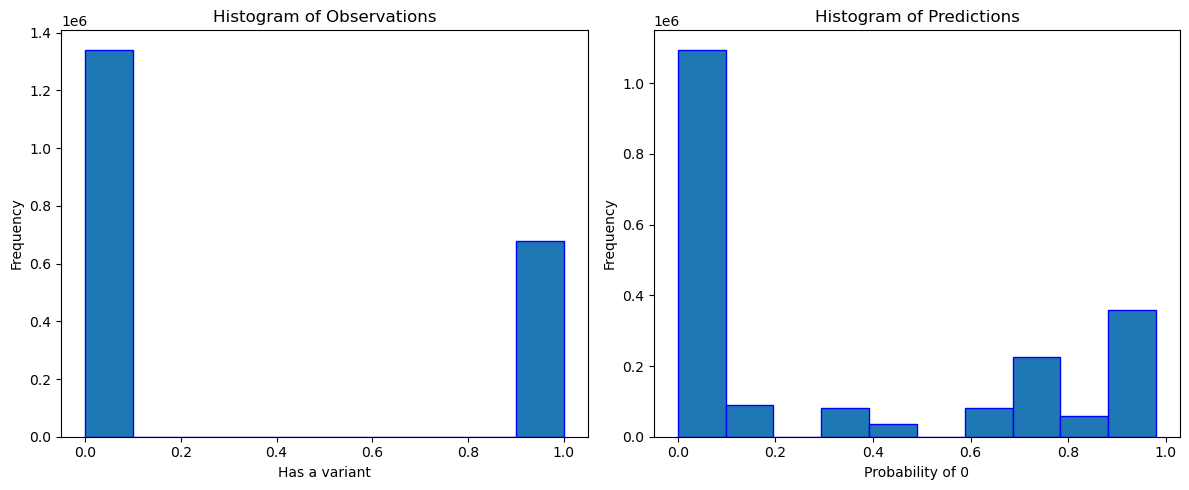

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 1.063e+06
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:26:30   Log-Likelihood:            -9.2474e+05
No. Observations:             2020621   AIC:                         1.849e+06
Df Residuals:                 2020619   BIC:                         1.850e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5757      0.000   1619.732      0.0

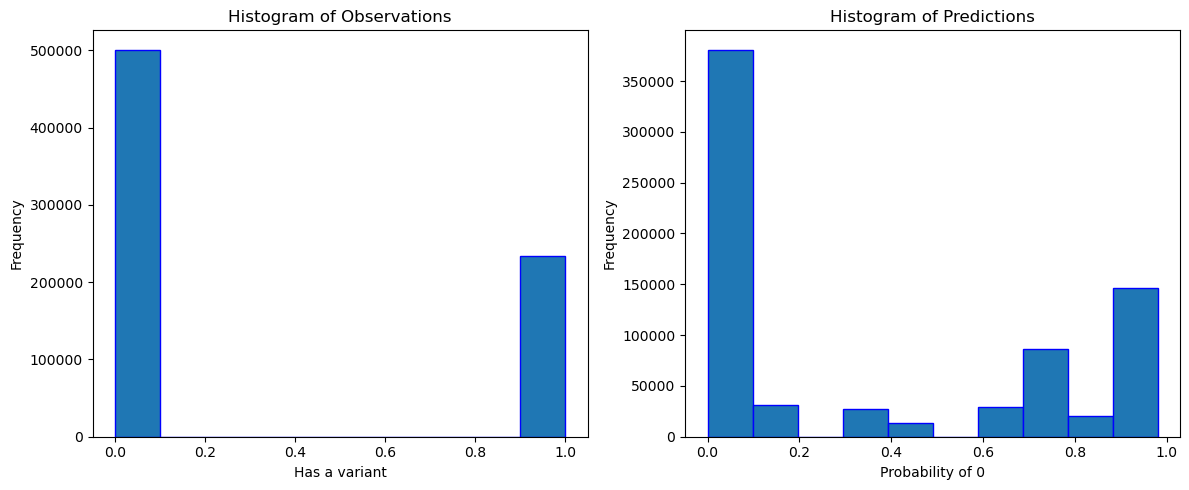

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                 3.996e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:27:33   Log-Likelihood:            -3.2196e+05
No. Observations:              734994   AIC:                         6.439e+05
Df Residuals:                  734992   BIC:                         6.440e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5699      0.001    964.063      0.0

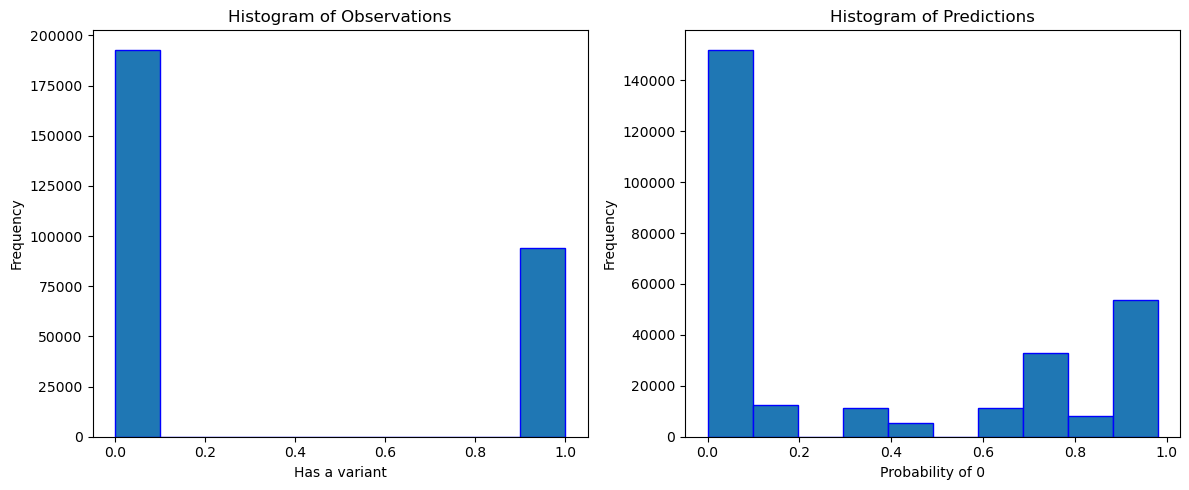

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                 1.532e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:28:36   Log-Likelihood:            -1.2856e+05
No. Observations:              286790   AIC:                         2.571e+05
Df Residuals:                  286788   BIC:                         2.571e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5725      0.001    605.847      0.0

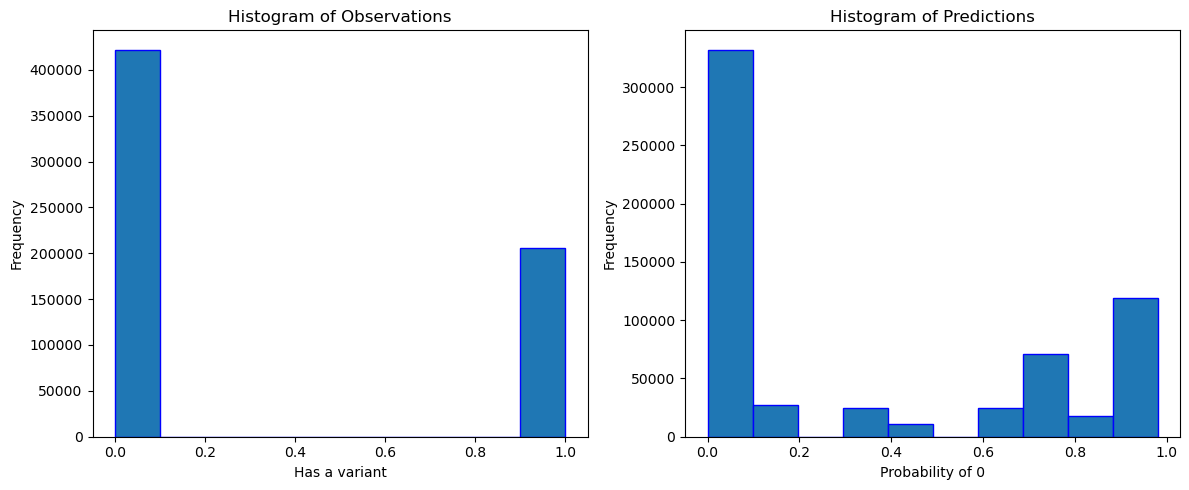

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                 3.369e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:29:38   Log-Likelihood:            -2.8075e+05
No. Observations:              627420   AIC:                         5.615e+05
Df Residuals:                  627418   BIC:                         5.615e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5733      0.001    897.833      0.0

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,1.819720e-35,1.000000,1.0
1,chr1,925923,9.853427e-03,0.990147,1.0
2,chr1,925924,1.367878e-01,0.863212,0.0
3,chr1,925925,1.043025e-02,0.989570,0.0
4,chr1,925926,3.126786e-03,0.996873,1.0
...,...,...,...,...,...
28933587,chr22,50777975,8.577066e-01,0.142293,0.0
28933588,chr22,50777976,6.976125e-01,0.302388,0.0
28933589,chr22,50777977,4.307699e-02,0.956923,0.0
28933590,chr22,50777978,5.493671e-03,0.994506,1.0


In [8]:
# Parameters for analysis
order = 2
coverage_thr = 0.9
coverage_category = 'over_20'

# Define coverage filter
# coverage_filter = '0.5_over10' # coverage['over_10'] > 0.5
coverage_filter = '0.9_over20' # coverage['over_20'] > 0.9

# Define model name (and absolute path)
model_name = results_path + 'HMM_rgc_' + coverage_filter + '_chr2'

# Load the pretrained model
model = joblib.load(model_name + '_model.joblib')

# Initialize empty dataframes
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observation'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_gene_df = gene_df[gene_df['chr'] == 'chr' + str(chromnum)]
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr' + str(chromnum)]
    chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr' + str(chromnum)) & (coverage_df[coverage_category] > coverage_thr)]
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df, gene_df=chr_gene_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Append predictions to overall df
    predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)

# Write predictions_df to a csv to avoid recomputing
predictions_df.to_csv(model_name + "_predictions_aou_wes.tsv.gz", index=False, compression='gzip', sep='\t')

predictions_df